# Introduction

This notebook contains the code, for running the circuit explained in the report. To run it easily, upload it on your IBMQ account and run it directly from their website (it will make it easier to run on the actual quantum computers).

Some parts of the code were insipred by the code done at https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py (it will be indicated), an implementation of the solution of a 4x4 system. The only difference is that in their implementation, they get an approximate solution to the problem. Here, we will find the exact solution to a specific 2x2 system.

# Problem statement

Here, we chose to design an HHL to solve the following system:

   $ A = \begin{bmatrix}
    4 & 1 \\
    1 & 4 \\
\end{bmatrix}, \textbf{b} = \begin{bmatrix}
    1 \\
    0 
\end{bmatrix}$

The solution to the problem $A\textbf{x} = \textbf{b}$ is $\textbf{x} = \begin{bmatrix}
    4/15 \\
    -1/15 \end{bmatrix}$, and the normalized state (the one output by the HHL circuit) should be $\tilde{\textbf{x}} = \begin{bmatrix}
    4/\sqrt{17} \\
    -1/\sqrt{17} \end{bmatrix}$.
    
Note that this is a specific problem, and as such, the design of the Quantum Phase Estimation (QPE) and the controlled Y rotations will depend on it.

For a full review of this specific case, please read section 8 of the report.

# Imports

In [29]:
%matplotlib inline

# Imports for Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *

# Various imports 
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt

# Load IBMQ account
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


# Functions to be used

In [47]:
def qft(circ, q, n):
    """Perform a n-bit QFT on specified quantum register in specified circuit.
    
    :circ: The circuit in which the QFT is performed
    :q: The quantum register on which to perform the QFT
    :n: The number of bits"""
    
    # Put the gates of the QFT circuit
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(np.pi/float(2**(k-j)), q[k], q[j])
    
    # Swap qubits
    for j in range(n//2):
        circ.swap(q[j], q[n-j-1])
        
def inv_qft(circ, q, n):
    """Perform an n-bit inverse QFT on specified quantum register in specified circuit.
    
    :circ: The circuit in which the QFT is performed
    :q: The quantum register on which to perform the QFT
    :n: the number of bits"""
    
    # Swap qubits
    for j in range(n//2):
        circ.swap(q[j], q[n-j-1])
        
    # Put the gates of the inverse QFT circuit
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cu1(-np.pi/float(2**(k-j)), q[k], q[j])
        circ.h(q[j])

In [60]:
def n_cry(circ, theta, control_qubits, target_qubit, inv = False):
    """Performs a n-controlled Y rotations of angle theta (n can be 1, 2 or 3).
    
    :circ: The circuit in which to perform the controlled rotations
    :theta: The angle of rotation
    :control_qubits: the qubits to be used as control (can be a list or quanutm register) but
                     the size of the register must be 1, 2 or 3
    :target_qubit: The target qubit
    :inv: To be set to True if the target qubit is above the control qubits in the circuit"""
    
    # Convert specified control qubits to a list
    control_list = control_qubits[:]
    size = len(control_list)
    
    
    if size > 3:
        print('Argument n is invalid!')
    else:
            
        if size == 1:
            circ.cry(theta, control_qubits[0], target_qubit)
        else:
            # To understand this part, please check section 6.3.1 of the report
            
            new_controls = control_qubits[:-1] if inv else control_qubits[1:]
            
            circ.mct(control_qubits, target_qubit, None, mode='advanced')
            n_cry(circ, -theta/2, new_controls, target_qubit, inv)
            circ.mct(control_qubits, target_qubit, None, mode='advanced')
            n_cry(circ, theta/2, new_controls, target_qubit, inv)

In [49]:
def postselect(statevector, qubit_number, value: bool):
    """Given a quantum state which is a tensor product of multiple qubits,
    compute the quantum state that would result if a specified qubit was found
    to be 1 or 0. 
    (Inspired by https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py,
    but slightly changed so that it better works)
    
    :statevector: The quantum state
    :qubit_number: The index of the qubit to be set to 1 or 0
    :value: The value to which the specified qubit is set
    """
    
    # Define a mask depending on the specified qubit
    mask = 1 << qubit_number
    
    # Depending on the desired value of the qubit, update the quantum state
    if value:
        array_mask = np.arange(len(statevector)) & mask
        array_mask = (array_mask != 0)
    else:
        array_mask = np.logical_not(np.arange(len(statevector)) & mask)
        
    def normalize(v):
        norm = np.linalg.norm(v)
        if norm == 0: 
           return v
        return v / norm
    
    # Return a normalized quantum state
    return normalize(statevector[array_mask])

The two following functions are designed for our problem specifically. Should the problem be different, the QPE circuit and HHL circuits should be adapted appropriately.

For how to design such circuits (more specifically controlled rotations in HHL), please read section section 6 and 8 of the report.

In [50]:
def qpe(circ, clock_reg, target):
    """Create the QPE circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :clock_reg: The quantum register holding the eigenvalues
    :target: The qubit on which the successive powers of the operator is applied"""
    
    # Perform a Hadamard Transform
    circ.h(clock_reg)
    
    # Apply successive powers of our operator
    circuit.h(target)
    circuit.crz(3*np.pi/2, clock_reg[2], target)
    circuit.h(target)
    
    circuit.h(target)
    circuit.crz(-np.pi, clock_reg[1], target)
    circuit.h(target)
    
    circuit.crz(2*np.pi, clock_reg[0], target)
    
    # Perform an inverse QFT on the register holding the eigenvalues
    inv_qft(circuit, clock_reg, 3)
    
def inv_qpe(circ, clock_reg, target):
    """Create the inverse QPE circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :clock_reg: The quantum register holding the eigenvalues
    :target: The qubit on which the successive powers of the operator is applied"""
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock_reg, 3)
    
    # Apply successive powers of our operator (in reverse)
    circuit.crz(-2*np.pi, clock_reg[0], target)
    
    circuit.h(target)
    circuit.crz(np.pi, clock_reg[1], target)
    circuit.h(target)
    
    circuit.h(target)
    circuit.crz(-3*np.pi/2, clock_reg[2], target)
    circuit.h(target)
    
    # Perform a Hadamard Transform
    circ.h(clock_reg)

In [51]:
def hhl(circ, ancilla_reg, clock_reg, input_reg, measurement_reg):
    """Create the HHL circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :ancilla_reg: The quantum register holding the ancilla qubit
    :clock_reg: The quantum register holding the eigenvalues
    :input_reg: The quantum register holding the input (what we call |b>)
    :measurement_reg: The classical register holding the results of the mesurements"""
    
    # Perform the QPE designed specifically for our problem
    qpe(circ, clock_reg, input_reg)
    
    # Perform the controlled Y-rotations (for a better understanding of
    # where the numbers come from, please check section 8 of the report)
    circuit.cry(2.89385, clock_reg[1], ancilla_reg[0])
    circuit.cry(1.69612, clock_reg[0], ancilla_reg[0])
    n_cry(circuit, 0.24774, clock_reg[1:], ancilla_reg[0], inv=True)
    n_cry(circuit, -0.40912, clock_reg[::2], ancilla_reg[0], inv=True)
    n_cry(circuit, -3.54277, clock_reg[:2], ancilla_reg[0], inv=True)
    
    # Perform the inverse QPE specifically designed for our problem
    inv_qpe(circ, clock_reg, input_reg)


# Circuit Creation

Here, we create the circuit to be used. Note that visually, the ancilla qubit is on top, followed by the clock register (register holding the eigenvalues), followed by the input qubit (which at the end of the circuit contains the solution, conditioned on the ancilla being 1).

This is important, as when we will do the conditioning on the ancilla qubit later, we need to specified the index of the qubit to be conditioned. In our case, the index will be 0 (since the ancilla is on top).

In [52]:
# Create the various registers needed
clock_reg = QuantumRegister(3, name='clock')
input_reg = QuantumRegister(1, name='input')
ancilla_reg = QuantumRegister(1, name='ancilla')
measurement_reg = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla_reg, clock_reg, input_reg, measurement_reg)

In [53]:
# Add the HHL circuit to the circuit
hhl(circuit, ancilla_reg, clock_reg, input_reg, measurement_reg)

# Save a version of the circuit with no measurement (useful for getting exact quantum state in simulator)
circuit_no_measure = deepcopy(circuit)

# Add measurements to the original circuit (for running on quantum computers)
circuit.measure(ancilla_reg, measurement_reg[0])
circuit.measure(input_reg, measurement_reg[1])

Below, we draw the full circuit:

In [ ]:
circuit.draw()

# Results

## On simulator, getting exact quantum state

We first run the circuit with "statevector_simulator" to try to retrieve the values of the quantum states, in order to get the actual solution.

In [54]:
# Use  QASM simulator
simulator = qiskit.BasicAer.get_backend('statevector_simulator')

# The code below was inspired by https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py,
# but slightly changed

# Compute the result of the simulation
res_state = execute([circuit_no_measure], simulator).result()

# Get the output vector (all qubits included)
full_state = res_state.get_statevector()

# Get the output vector conditioned on ancilla value being 1
statevector = postselect(full_state, 0, value=1)

# This is hardcoded, in our case, need to select first and ninth
# element of the statevector to recover the solution
# These are the amplitudes for the value of x being 0 or 1,
# and values all 0 for the clock register, which in the final
# vector is on coordinates 0 and 8 
# (compute the tensor product of qubits to see why if unclear).
selector = np.zeros(16)
selector[0] = 1
selector[8] = 1
selector = (selector != 0)

# Get the output for qubit containing solution
x_experimental = statevector[selector]

# Multiply the quantum state of solution by constant to get the
# right answer (recall HHL gives a solution proportional to the true one)
solution = np.sqrt(17) * x_experimental

# The actual solution
x_exact = np.array([4, -1])

print("Exact solution: {}".format(x_exact))
print("Experimental solution: {}".format(solution))
print("Error in found solution: {}".format(np.linalg.norm(solution - x_exact)))

Exact solution: [ 4 -1]
Experimental solution: [ 3.99999935-6.22282218e-15j -1.00000261+0.00000000e+00j]
Error in found solution: 2.6892192924235157e-06


We note that as expected, on the simulator we get the exact correct solution. Below, we show the amplitudes of the final state (when no conditioning is done on the ancilla qubit).

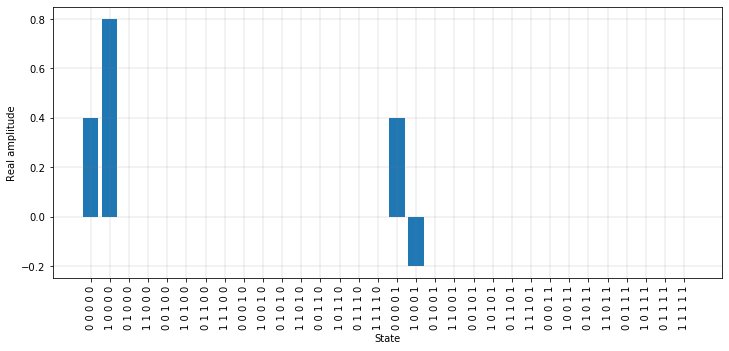

In [55]:
# The code below was inspired by https://github.com/nelimee/quantum-hhl-4x4/blob/master/hhl4x4/4x4.py,
# but slightly changed to have a better visualization

n_states = len(full_state)
x_axis_values = np.arange(n_states)
x_axis_binary = [' '.join(bin(n)[3:])[::-1] for n in np.arange(n_states, 2 * n_states)]

plt.figure(figsize=(12, 5))
plt.grid(color='gray', linewidth =0.2)
plt.bar(x_axis_values, np.real(full_state))
plt.xticks(x_axis_values, x_axis_binary, rotation='vertical')
plt.ylabel('Real amplitude')
plt.xlabel('State')
plt.show()

## On simulator, getting statistics of measurements

Here, we run the circuit, but this time using the "qasm_simulator" and getting the statistics of measurements.

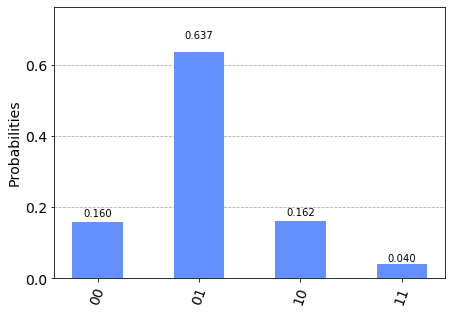

In [56]:
# Execute the circuit using the simulator
simulator = qiskit.BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# Display the results
plot_histogram(counts)

Note that here, rescaling after conditioning on the ancilla qubit being one, we get an estimated probability of $0.641 / (0.641 + 0.04) \approx 0.941$ of measuring 0 for $|x>$ and an estimated probability of $0.04 / (0.641 + 0.04) \approx 0.059$ of measuring 1, as expected for our problem.

Indeed recall the expected solution to be $\tilde{\textbf{x}} = \begin{bmatrix}
    4/\sqrt{17} \\
    -1/\sqrt{17} \end{bmatrix}$, and so the probability of getting 0 is $|4/\sqrt{17}|^2 \approx 0.941$ and the probability of getting 1 is $|-1/\sqrt{17}|^2 \approx 0.059$.

## On IBM's computers, getting statistics of measurements

Here, we run the circuit, but this time using one of IBM's quantum computer and getting the statistics of measurements.

In [57]:
IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [58]:
# Choose the backend on which to run the circuit
backend = provider.get_backend('ibmq_essex')

from qiskit.tools.monitor import job_monitor

# Execute the job
job_exp = execute(circuit, backend=backend, shots=8192)

# Monitor the job to know where we are in the queue
job_monitor(job_exp, interval = 2)

Job Status: job has successfully run


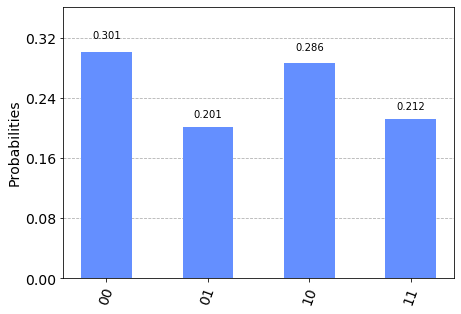

In [61]:
# Get the results from the computation
results = job_exp.result()

# Get the statistics
answer = results.get_counts(circuit)

# Plot the results
plot_histogram(answer)

Note that here, rescaling after conditioning on the ancilla qubit being one, we get an estimated probability of $0.201 / (0.201 + 0.212) \approx 0.487$ of measuring 0 for $|x>$ and an estimated probability of $0.212 / (0.201 + 0.212) \approx 0.513$ of measuring 1, which is not close to the expected solution.

Indeed recall the expected solution to be $\tilde{\textbf{x}} = \begin{bmatrix}
    4/\sqrt{17} \\
    -1/\sqrt{17} \end{bmatrix}$, and so the probability of getting 0 is $|4/\sqrt{17}|^2 \approx 0.941$ and the probability of getting 1 is $|-1/\sqrt{17}|^2 \approx 0.059$.
    
This can be explained by the fact that our circuit contains many gates and such, a lot of noise is introduced resulting in a corrupted solution.